# Prerequisites

For this exercise we will need the `statsmodels` and `pmdarima` libraries.

`conda install -c conda-forge statsmodels pmdarima`

Sources for further exploration:
* https://www.timescale.com/blog/how-to-work-with-time-series-in-python
* https://filippomb.github.io/python-time-series-handbook/notebooks/01/introduction_to_time_series.html
* https://builtin.com/data-science/time-series-python

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# One of the modules reports prodigious warnings so we will just hide these ;)
import warnings
warnings.filterwarnings("ignore")

# What is time series data?
* A time series is a sequence of data points organized in time order.
* Usually, the time signal is sampled at equally spaced points in time.
* These can be represented as the sequence of the sampled values.
* We refer to this setting as discrete time.

## Time series components
A time series is often assumed to be composed of three components:
* Trend: the long-term direction.
* Seasonality: the periodic behavior.
* Residuals: the irregular fluctuations.

# Trend
* Trend captures the general direction of the time series.
* For example, increasing number of passengers over the years despite seasonal fluctuations.
* Trend can be increasing, decreasing, or constant.
* It can increase/decrease in different ways over time (linearly, exponentially, etc…).

In [4]:
time = np.arange(144)
trend = time * 2.65 +100

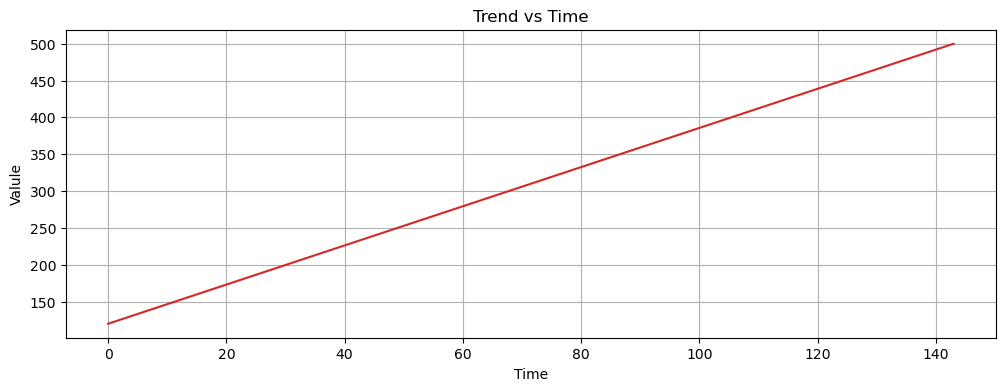

In [119]:
plt.figure(figsize=(12, 4))

plt.plot(time, trend, color='tab:red')
plt.xlabel("Time")
plt.ylabel("Valule")
plt.grid()
plt.title("Trend vs Time");

# Seasonality
* Periodic fluctuations in time series data that occur at regular intervals due to seasonal factors.
* It is characterized by consistent and predictable patterns over a specific period (e.g., daily, monthly, quarterly, yearly).

In [12]:
seasonal = 20 + np.sin( time * 0.5) * 20

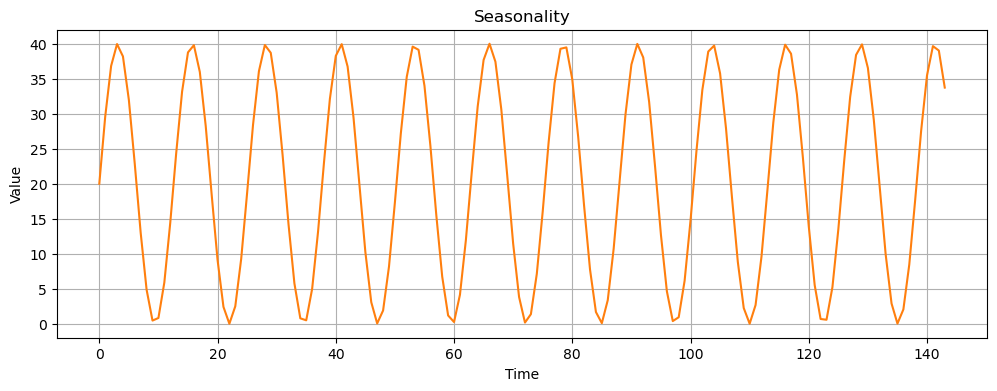

In [120]:
plt.figure(figsize=(12, 4))

plt.plot(time, seasonal, color='tab:orange')
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid()
plt.title("Seasonality");

# Residuals
* Residuals are the random fluctuations left over after trend and seasonality are removed from the original time series.
* One should not see a trend or seasonal pattern in the residuals.
* They represent short term, rather unpredictable fluctuations.

In [15]:
residuals = np.random.normal(loc=0.0, scale=3, size=len(time))

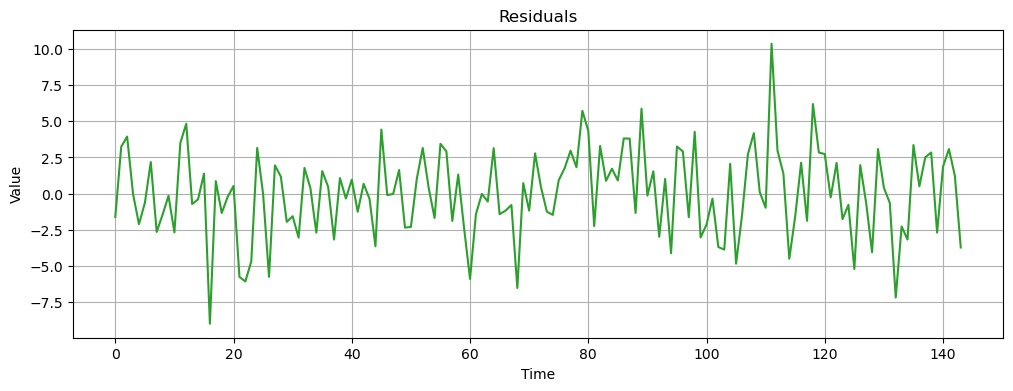

In [121]:
plt.figure(figsize=(12, 4))

plt.plot(time, residuals, color='tab:green')
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid()
plt.title("Residuals");

# Decomposition Models
Time series components can be decomposed with the following models:
* Additive decomposition
* Multiplicative decomposition
* Other more complicated models that we won't discuss

## Additive model
Additive models assume that the observed time series is the sum of its components:

X(t) = T(t) + S(t) + R(t)

where
* X(t) is the time series
* T(t) is the trend
* S(t) is the seasonality
* R(t) is the residual

Additive models are used when the magnitudes of the seasonal and residual values do not depend on the level of the trend.

In [123]:
additive = trend + seasonal + residuals

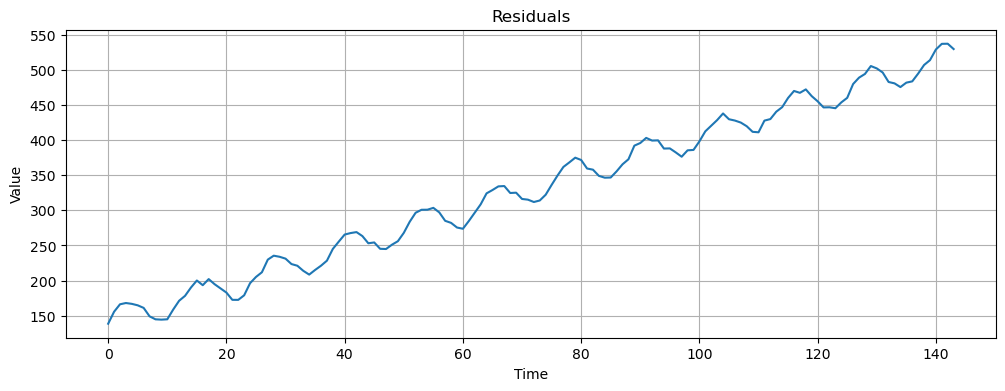

In [124]:
plt.figure(figsize=(12, 4))

plt.plot(time, additive, color='tab:blue')
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid()
plt.title("Residuals");

# Multiplicative Model
Assumes that the observed time series is the product of its components:

X(t) = T(t) * S(t) * R(t)

Multiplicative models are used when the magnitudes of seasonal and residual values depends on trend.

In [34]:
multiplicative = trend * seasonal # * np.abs(residuals) # <- Plotting w/o residuals to show the pattern

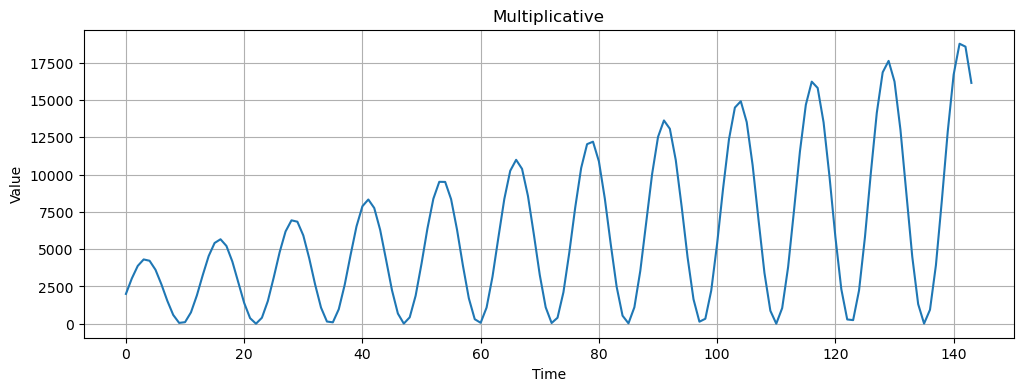

In [125]:
plt.figure(figsize=(12, 4))

plt.plot(time, multiplicative, color='tab:blue')
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid()
plt.title("Multiplicative");

# De-trending a time series
Now we have seen how to build up a time series from component parts. In reality this is not the way that it works, typically
we will have a timeseries dataset from observations and we would like to **figure out** what the different components are.
A very simple, yet often useful, approach is to estimate a linear trend. A detrended time series is obtained by subtracting the linear 
trend from the data. The linear trend is computed as a 1st order polynomial.

In [126]:
slope, intercept = np.polyfit(np.arange(len(additive)), additive, 1) # estimate line coefficient

trend = np.arange(len(additive)) * slope + intercept # linear trend

detrended = additive - trend # remove the trend

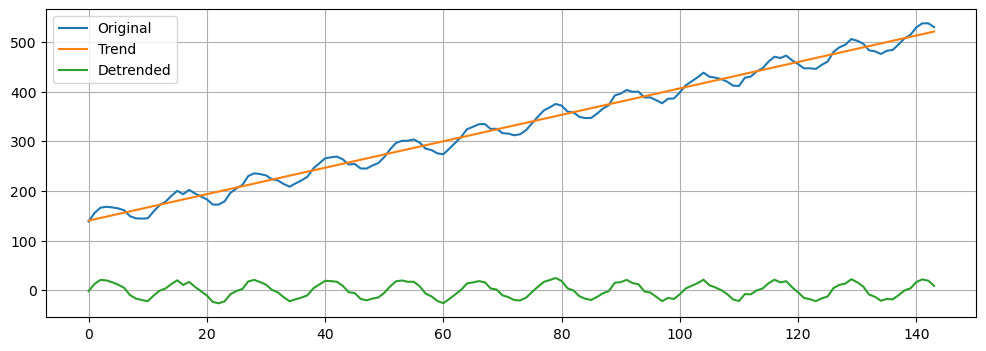

In [127]:
plt.figure(figsize=(12, 4))
plt.plot(additive, label='Original')
plt.plot(trend, label='Trend')
plt.plot(detrended, label='Detrended')
plt.grid()
plt.legend();

# Additive Decomposition 
Next, we will use [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) to isolate the main time series components.

We need to specify an integer that represents the main seasonality of the data. By looking at the seasonal component, we see that 
the period is approximately 12 time steps long, so set period=12.

From the [documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html): "This is a naive decomposition. More sophisticated methods should be preferred."

In [128]:
additive_decomposition = seasonal_decompose(x=additive, model='additive', period=12)

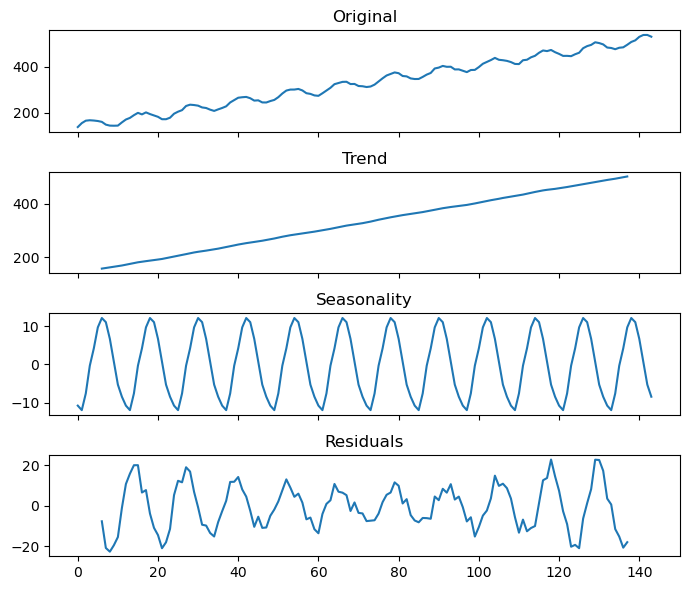

In [129]:
# A helper function to plot the original time series, and the 3 decomposed components
def seas_decomp_plots(original, decomposition):
    _, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(7, 6))
    axes[0].plot(original)
    axes[0].set_title('Original')
    axes[1].plot(decomposition.trend)
    axes[1].set_title('Trend')
    axes[2].plot(decomposition.seasonal)
    axes[2].set_title('Seasonality')
    axes[3].plot(decomposition.resid)
    axes[3].set_title('Residuals')
    plt.tight_layout()
    plt.show()
seas_decomp_plots(additive, additive_decomposition)

### Challenge exercise
Implement `seasonal_decompose` for the multiplicative model and evaluate the results.

# Forecasting with Auto Regressive Integrated Moving Average (ARIMA)
Time series forecasting allows us to predict future values in a time series given current and past data. Python offers a variety 
of libraries and techniques for time-series forecasting, and one popular method is the autoregressive integrated moving average 
(ARIMA) model. ARIMA is a powerful and widely used approach that combines the three following components to capture the patterns 
and trends in time-series data:
1. Autoregression (AR)
2. Differencing (I)
3. Moving Average (MA)

Here, we will use the `pmdarima` package [ARIMA](https://pypi.org/project/pmdarima/) method to forecast change in time for our
synthetic `additive` dataset, which allows us to forecast future values in terms of a linear combination of past values.
`statsmodels` also has an [ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html) module but
it's slightly more complicated and `pmdarima` does a lot nice things to make this method easier for us.

In [110]:
## Get the length of our input time series
max_x = additive.shape[-1]
max_x

144

### Test/train split
First we need to split our additive data into a test and train set, with the idea that we will train ARIMA
on the train data. Once the model is fitted, you can use it to forecast future values by calling the predict method, then we can 
compare the prediction to the 'true' values to see how well it did.

Text(0.5, 0, 'Time')

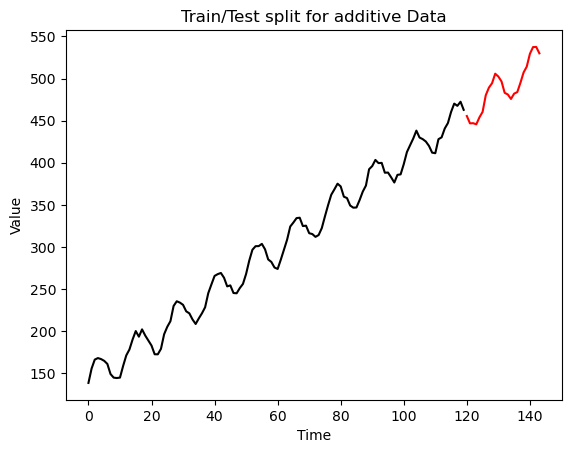

In [130]:
# We'll split at index 120, which will leave 24 timepoints to predict in the train set
split_idx = 120

# For plotting we need x-coords for the full dataset so make a list of [1, 2, .., max_x]
xs = list(range(max_x))

# Split the train data and the x-coords
train = additive[:split_idx]
xs_train = xs[:split_idx]

# Split the test data and the remaining x-coords
test = additive[split_idx:]
xs_test = xs[split_idx:]

# Plot the test and train data to see the 'truth' value of the test set
plt.plot(xs_train, train, color = "black")
plt.plot(xs_test, test, color = "red")
plt.title("Train/Test split for additive Data")
plt.ylabel("Value")
plt.xlabel("Time")

## Train the ARIMA model and predict future values
`auto_arima` has a very similar API to `scikit-learn` which we have seen previously, with `fit()` and `predict()` methods
for the ARIMA model

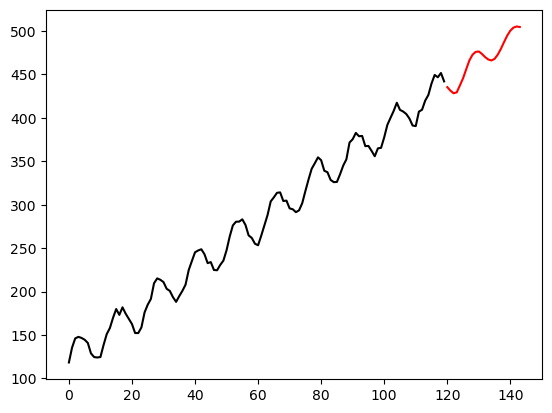

In [116]:
from pmdarima.arima import auto_arima

# Train the model on the training data
model = auto_arima(train)
model.fit(train)

# Predict the next n timepoints corresponding to the length of the test set
forecast = model.predict(n_periods=len(test))

# Plot the results
plt.plot(xs_train, train, color = "black")
plt.plot(xs_test, forecast, color = "red")

**Pretty Good!**

# Challenge exercises

The `statsmodels` library has several different timeseries datasets built in. Here you will load 
two different time series example datasets and work through the analysis that we just practiced above.

* Plot the two time series.
* Determine if the time series look like additive or multiplicative models.
* Based on your judgement decompose each time series into component parts (assume a period of 12).
* Split each dataset into test and train sets, train an ARIMA model and predict the held-out test set. Compare
the prediction to the 'true' value. How does ARIMA perform on each of these datasets?


In [131]:
import statsmodels.api as smf
ts_A = sm.datasets.get_rdataset("AirPassengers", "datasets").data["value"].values
print(len(ts_A))
ts_B = sm.datasets.get_rdataset("co2", "datasets").data["value"].values
print(len(ts_B))

144
468
